In [1]:
import pandas as pd
import numpy as np
import uproot
import os
import xgboost as xgb
import awkward as ak
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Produce Data


path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/mmatthew/Patatrack15/Samples/CloseByPion/histo"

cp_energy = []
tkx_energy = []
tkx_nclus = []
tkx_barycentre = []
tkx_energyfraction = []
frac_energy = []
tkx_numtkx = []
cell_type = []
weighted_bar_x = []
weighted_bar_y = []
weighted_bar_z = []


for root, dirs, files in os.walk(path):
    for i,file in enumerate(files):
        if i >= 100 :
            break
        f = uproot.open(os.path.join(path,file))
        energy = np.array([ak.sum(x) for x in f["ticlDumper/trackstersMerged"]["raw_energy"].array()])
        if (energy==0).any(): 
            print(file, "contains faulty event!!! Excluded for now!!!")
            continue       
        
        cp_energy.append([ak.sum(x) for x in f["ticlDumper/simtrackstersCP"]["regressed_energy"].array()])
        tkx_energy.append([ak.sum(x) for x in f["ticlDumper/trackstersMerged"]["raw_energy"].array()])  
        tkx_numtkx.append([ak.count(x) for x in f["ticlDumper/trackstersMerged"]["raw_energy"].array()])
        
        bar_x = f["ticlDumper/trackstersMerged"]["barycenter_x"].array(library="np")
        bar_y = f["ticlDumper/trackstersMerged"]["barycenter_y"].array(library="np")
        bar_z = f["ticlDumper/trackstersMerged"]["barycenter_z"].array(library="np")

        weights = [np.array(x)/np.sum(np.array(x)) for x in f["ticlDumper/trackstersMerged"]["raw_energy"].array()]

        weighted_bar_x.append([np.sum([x*l]) for x, l in zip(weights, bar_x)])
        weighted_bar_y.append([np.sum([x*l]) for x, l in zip(weights, bar_y)])
        weighted_bar_z.append([np.sum([x*l]) for x, l in zip(weights, bar_z)])
        
        cell_type.append([np.array(ak.sum(x,axis=0)) for x in f["ticlDumper/trackstersMerged"]["raw_energy_perCellType"].array()])
                

        
cell_type = np.array([y for x in cell_type for y in x])
frac = np.array(cell_type)/np.array(tkx_energy).reshape(-1, 1)
d1, d2, d3, d4, d5, d6, d7 = np.hsplit(frac, 7)
cp_energy = np.array(cp_energy).flatten()
tkx_energy = np.array(tkx_energy).flatten()
tkx_numtkx = np.array(tkx_numtkx).flatten()
weighted_bar_x = np.array(weighted_bar_x).flatten()
weighted_bar_y = np.array(weighted_bar_y).flatten()
weighted_bar_z = np.array(weighted_bar_z).flatten()

histo_9373196_109.root contains faulty event!!! Excluded for now!!!
histo_9373196_127.root contains faulty event!!! Excluded for now!!!
histo_9373196_128.root contains faulty event!!! Excluded for now!!!
histo_9373196_13.root contains faulty event!!! Excluded for now!!!
histo_9373196_137.root contains faulty event!!! Excluded for now!!!
histo_9373196_14.root contains faulty event!!! Excluded for now!!!
histo_9373196_142.root contains faulty event!!! Excluded for now!!!
histo_9373196_144.root contains faulty event!!! Excluded for now!!!
histo_9373196_15.root contains faulty event!!! Excluded for now!!!
histo_9373196_23.root contains faulty event!!! Excluded for now!!!
histo_9373196_36.root contains faulty event!!! Excluded for now!!!
histo_9373196_37.root contains faulty event!!! Excluded for now!!!
histo_9373196_38.root contains faulty event!!! Excluded for now!!!
histo_9373196_4.root contains faulty event!!! Excluded for now!!!
histo_9373196_40.root contains faulty event!!! Excluded f

In [3]:
# Create DataFrame
d = {
    "frac": np.array(tkx_energy).flatten()/np.array(cp_energy).flatten(),
    "cp_energy":cp_energy,
    "tkx_energy":tkx_energy,
    "tkx_numtkx":tkx_numtkx,
    "weighted_bar_x":weighted_bar_x,
    "weighted_bar_y":weighted_bar_y,
    "weighted_bar_z":weighted_bar_z,
    "CE_E_120":d1.flatten(),
    "CE_E_200":d2.flatten(),
    "CE_E_300":d3.flatten(),
    "CE_H_120":d4.flatten(),
    "CE_H_200":d5.flatten(),
    "CE_H_300":d6.flatten(),
    "CE_H_SCINT":d7.flatten()
}

df = pd.DataFrame(d)

In [4]:
df 
train, test = train_test_split(df, test_size=0.2)
y_train = train["cp_energy"]
X_train = train.drop(["frac","cp_energy"],axis=1)
y_test = test["cp_energy"]
X_test = test.drop(["frac","cp_energy"],axis=1)

In [5]:
regressor=xgb.XGBRegressor(learning_rate = 0.005,
                           n_estimators  = 1700,
                           max_depth     = 3,
                           eval_metric='rmse')

In [6]:
regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

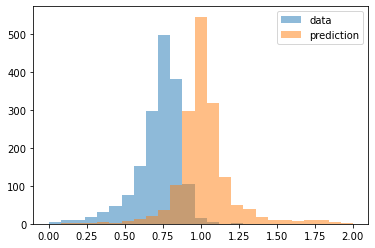

In [7]:
plt.hist(test["frac"],range=[0,2],bins = 25,alpha=0.5,label="data")
plt.hist(predictions/test["cp_energy"],range=[0,2],bins = 25,alpha=0.5,label="prediction")
plt.legend()